In [4]:
x = [[5,7,8], [6,3], [3], [1]]

In [5]:
import helpers
xt, xlen = helpers.batch(x)

In [7]:
x

[[5, 7, 8], [6, 3], [3], [1]]

In [9]:
xt

array([[5, 6, 3, 1],
       [7, 3, 0, 0],
       [8, 0, 0, 0]])

In [10]:
xlen

[3, 2, 1, 1]

In [11]:
#Building a model
#Simple seq2seq

import numpy as np
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [12]:
tf.__version__

'1.1.0'

In [13]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

In [14]:
encoder_inputs = tf.placeholder(shape = (None, None), dtype = tf.int32, name = 'encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype = tf.int32, name = 'decoder_targets')

In [15]:
decoder_inputs = tf.placeholder(shape = (None, None), dtype = tf.int32, name = 'decoder_inputs')

In [16]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype = tf.float32)

In [17]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [18]:
#Encoder

encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded, 
    dtype = tf.float32, time_major = True,
)

del encoder_outputs

In [19]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [22]:
#Decoder

decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded, 
    initial_state = encoder_final_state, 
    dtype = tf.float32, time_major = True, scope = "plain_decoder",
)

In [23]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)
decoder_prediction = tf.argmax(decoder_logits, 2)

In [24]:
decoder_logits

<tf.Tensor 'fully_connected/BiasAdd:0' shape=(?, ?, 10) dtype=float32>

In [26]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels = tf.one_hot(decoder_targets, depth = vocab_size, dtype = tf.float32),
    logits = decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [27]:
sess.run(tf.global_variables_initializer())

In [29]:
#Test Forward Pass

batch_ = [[6], [3,4], [9,8,7]]

batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3,1), dtype = np.int32), 
                            max_sequence_length = 4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
                 feed_dict={
                     encoder_inputs: batch_,
                     decoder_inputs: din_,
                 })
print('decoder predictions:\n'+ str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[6 8 2]
 [4 8 4]
 [4 4 4]
 [4 4 4]]


In [30]:
#training on the toy task

batch_size = 100


batches = helpers.random_sequences(length_from=3, length_to = 8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[7, 4, 5]
[2, 3, 3, 9, 3]
[6, 6, 9, 9]
[9, 6, 8, 8, 9]
[4, 4, 8, 4]
[3, 9, 9, 7, 5, 7]
[3, 7, 4, 6, 2, 6]
[4, 6, 5, 4]
[2, 3, 8]
[4, 5, 8, 7, 7, 9, 9, 6]


In [31]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS]+(sequence) for sequence in batch]
    )
    return{
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [32]:
loss_track = []

In [36]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i , (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('   sample {}'.format(i+1))
                print('     input    > {}'.format(inp))
                print('     predicted> {}'.format(pred))
                if i >=2:
                    break
            print()
            
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.2635700702667236
   sample 1
     input    > [5 3 5 3 5 7 0 0]
     predicted> [5 7 8 0 0 0 1 0 8]
   sample 2
     input    > [2 6 5 5 8 0 0 0]
     predicted> [4 8 8 0 0 1 0 4 4]
   sample 3
     input    > [3 2 5 0 0 0 0 0]
     predicted> [6 8 8 8 0 8 4 4 4]

batch 1000
  minibatch loss: 0.3209713101387024
   sample 1
     input    > [9 8 4 9 8 5 0 0]
     predicted> [9 8 4 9 8 5 1 0 0]
   sample 2
     input    > [3 6 4 7 2 0 0 0]
     predicted> [3 6 4 7 2 1 0 0 0]
   sample 3
     input    > [5 8 4 8 2 9 7 4]
     predicted> [8 8 4 8 2 7 7 4 1]

batch 2000
  minibatch loss: 0.1446244716644287
   sample 1
     input    > [4 9 6 3 0 0 0 0]
     predicted> [4 9 6 3 1 0 0 0 0]
   sample 2
     input    > [7 6 6 3 6 0 0 0]
     predicted> [6 6 6 3 6 1 0 0 0]
   sample 3
     input    > [6 2 6 0 0 0 0 0]
     predicted> [6 2 6 1 0 0 0 0 0]

batch 3000
  minibatch loss: 0.10052193701267242
   sample 1
     input    > [5 5 9 3 6 8 6 3]
     predicted> [5 5 9 

loss 0.1076 after 300400 examples (batch_size=100)


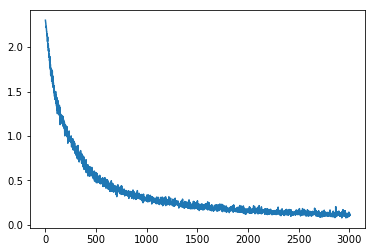

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))